Loading Data    

In [ ]:
# Importing modules
import pandas as pd
import os
# Read data into papers
papers = pd.read_csv('full_context_PeerRead.csv')
# Print head
papers.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,right_citated_text,left_citated_text,source_abstract,source_author,source_id,source_title,source_venue,source_year,target_id,target_author,target_abstract,target_year,target_title,target_venue
0,andsyntactic parsing .Because RNNs make very f...,We conducted additional experiments on artific...,Deep Neural Networks (DNNs) are powerful model...,ilya sutskever;oriol vinyals;quoc v le,1409.3215v1,Sequence to Sequence Learning with Neural Netw...,NIPS,2014.0,1606.03622v1,robin jia;percy liang,Modeling crisp logical regularities is crucial...,2016,Data Recombination for Neural Semantic Parsing,ACL
1,.Because RNNs make very few domain-specific as...,We conducted additional experiments on artific...,Syntactic parsing is a fundamental problem in ...,oriol vinyals;lukasz kaiser;terry koo;slav pet...,1412.7449v1,Grammar as a Foreign Language,NIPS,2014.0,1606.03622v1,robin jia;percy liang,Modeling crisp logical regularities is crucial...,2016,Data Recombination for Neural Semantic Parsing,ACL
2,"; in a Pointer Network,the only way to generat...","Reproducibility. All code, data, and experimen...",We introduce a new neural architecture to lear...,oriol vinyals;meire fortunato;navdeep jaitly,1506.03134v1,Pointer Networks,NIPS,2015.0,1606.03622v1,robin jia;percy liang,Modeling crisp logical regularities is crucial...,2016,Data Recombination for Neural Semantic Parsing,ACL
3,". Recently, nsur . have shown superior perfor...","st like CWS and POS tagging, automatic prosody...",The recently introduced continuous Skip-gram m...,tomas mikolov;ilya sutskever;kai chen 0010;gre...,1310.4546v1,Distributed Representations of Words and Phras...,NIPS,2013.0,1511.00360v1,chuang ding;lei xie;jie yan;weini zhang;yang liu,Prosody affects the naturalness and intelligib...,2015,Automatic Prosody Prediction for Chinese Speec...,arxiv
4,model trained on the Google News dataset3.In a...,We begin by considering a document as the set ...,The recently introduced continuous Skip-gram m...,tomas mikolov;ilya sutskever;kai chen 0010;gre...,1310.4546v1,Distributed Representations of Words and Phras...,NIPS,2013.0,1705.10900v1,paul michel;abhilasha ravichander;shruti rijhwani,We investigate the pertinence of methods from ...,2017,Does the Geometry of Word Embeddings Help Docu...,arxiv


Data Cleaning

In [ ]:
# Remove the columns
papers = papers.drop(columns=['source_author', 'source_id',
                              'source_venue', 'target_id', 'target_author',
                              'target_abstract', 'target_year', 'target_title',
                              'target_venue'], axis=1)
# Print out the first rows of papers
papers.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,right_citated_text,left_citated_text,source_abstract,source_title,source_year
0,andsyntactic parsing .Because RNNs make very f...,We conducted additional experiments on artific...,Deep Neural Networks (DNNs) are powerful model...,Sequence to Sequence Learning with Neural Netw...,2014.0
1,.Because RNNs make very few domain-specific as...,We conducted additional experiments on artific...,Syntactic parsing is a fundamental problem in ...,Grammar as a Foreign Language,2014.0
2,"; in a Pointer Network,the only way to generat...","Reproducibility. All code, data, and experimen...",We introduce a new neural architecture to lear...,Pointer Networks,2015.0
3,". Recently, nsur . have shown superior perfor...","st like CWS and POS tagging, automatic prosody...",The recently introduced continuous Skip-gram m...,Distributed Representations of Words and Phras...,2013.0
4,model trained on the Google News dataset3.In a...,We begin by considering a document as the set ...,The recently introduced continuous Skip-gram m...,Distributed Representations of Words and Phras...,2013.0


Remove punctuation/lower casing (SOURCE ABSTRACT FOCUS)

In [ ]:
# Load the regular expression library
import re
# Remove punctuation
papers['paper_text_processed'] = \
papers['source_abstract'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
papers['paper_text_processed'] = \
papers['paper_text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
papers['paper_text_processed'].head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:5: DeprecationWarning: invalid escape sequence '\.'
<>:5: DeprecationWarning: invalid escape sequence '\.'
<ipython-input-9-394f5b1e56d0>:5: DeprecationWarning: invalid escape sequence '\.'
  papers['source_abstract'].map(lambda x: re.sub('[,\.!?]', '', x))


0    deep neural networks (dnns) are powerful model...
1    syntactic parsing is a fundamental problem in ...
2    we introduce a new neural architecture to lear...
3    the recently introduced continuous skip-gram m...
4    the recently introduced continuous skip-gram m...
Name: paper_text_processed, dtype: object

Exploratory Analysis


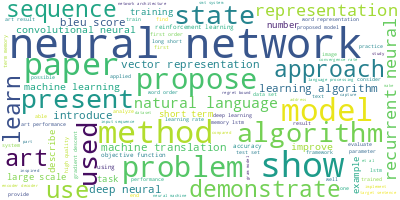

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()


Prepare data for LDA Analysis

In [ ]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]
data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['deep', 'neural', 'networks', 'dnns', 'powerful', 'models', 'achieved', 'excellent', 'performance', 'difficult', 'learning', 'tasks', 'although', 'dnns', 'work', 'well', 'whenever', 'large', 'labeled', 'training', 'sets', 'available', 'cannot', 'used', 'map', 'sequences', 'sequences', 'paper', 'present', 'general']


In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


LDA model training


In [ ]:
from pprint import pprint
# number of topics
num_topics = 4
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.013*"neural" + 0.012*"network" + 0.011*"networks" + 0.010*"lstm" + '
  '0.010*"learning" + 0.009*"deep" + 0.009*"training" + 0.009*"model" + '
  '0.008*"models" + 0.007*"sequence"'),
 (1,
  '0.011*"learning" + 0.011*"model" + 0.011*"models" + 0.007*"algorithms" + '
  '0.006*"state" + 0.006*"tasks" + 0.005*"using" + 0.005*"neural" + '
  '0.005*"art" + 0.005*"performance"'),
 (2,
  '0.018*"model" + 0.010*"data" + 0.009*"learning" + 0.009*"neural" + '
  '0.007*"based" + 0.007*"show" + 0.007*"words" + 0.006*"models" + '
  '0.006*"state" + 0.006*"performance"'),
 (3,
  '0.016*"method" + 0.013*"learning" + 0.011*"also" + 0.010*"representations" '
  '+ 0.009*"data" + 0.009*"optimization" + 0.009*"algorithm" + '
  '0.008*"stochastic" + 0.008*"gradients" + 0.008*"word"')]


In [ ]:
!pip install pyLDAvis
import pyLDAvis.gensim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 28.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.24.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.1 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.2.1 which is incompatible.


Analyzing LDA model results


In [ ]:
import pyLDAvis.gensim
import pickle
import pyLDAvis
import os
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./lda_modeling'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './lda_modeling'+ str(num_topics) +'.html')
LDAvis_prepared

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.061337  0.099044       1        1  31.337846
2      0.065218 -0.011858       2        1  27.400057
1      0.040724 -0.095605       3        1  23.360966
3     -0.167279  0.008419       4        1  17.901131, topic_info=             Term         Freq        Total Category  logprob  loglift
47           lstm  5033.000000  5033.000000  Default  30.0000  30.0000
55         method  8427.000000  8427.000000  Default  29.0000  29.0000
475     gradients  2153.000000  2153.000000  Default  28.0000  28.0000
61   optimization  3836.000000  3836.000000  Default  27.0000  27.0000
449    stochastic  2799.000000  2799.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
69        present  1290.352182  4500.738768   Topic4  -5.2821   0.4710
63          paper  1341.621004  6030.336547   Topic4  -5.2431   0.2174
136       results  1183.063821  6060.773695   Topic4  -5.3689   0.0866
59       networks  1178.908803  9031.666903   Topic4  -5.3724  -0.3158
138          show  1164.138155  7426.568936   Topic4  -5.3850  -0.1328

[409 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1413      2  0.985958      academic
1413      3  0.008803      academic
2115      3  0.995251  accomplishes
2463      1  0.005175      adadelta
2463      2  0.010350      adadelta
...     ...       ...           ...
4034      1  0.011664     workloads
4034      2  0.005832     workloads
4034      3  0.017497     workloads
4034      4  0.962309     workloads
5367      1  0.980814          wrns

[1125 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])